# Binary-Class Model for Heart Disease Key Indicators Using TensorFlow Decision Forests
### David Lowe
### March 3, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Heart Disease Key Indicators dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: This dataset comes from the CDC's Behavioral Risk Factor Surveillance System (BRFSS) study, which conducts annual telephone surveys to gather data on the health status of U.S. residents. The original dataset consists of 401,958 rows and 279 columns. However, the Kaggle project owner selected some of the most relevant attributes from the dataset and cleaned it up for machine learning projects.

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved a ROC-AUC benchmark of 88.47% on the training dataset. When we applied the finalized model to the test dataset, the model achieved a ROC-AUC score of 83.17%.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Personal Key Indicators of Heart Disease Dataset

Dataset ML Model: Binary classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/kamilpytlak/personal-key-indicators-of-heart-disease

One source of potential performance benchmarks: https://www.kaggle.com/kamilpytlak/personal-key-indicators-of-heart-disease/code

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]

# Define the directory locations and file names
TRAIN_DATASET = 'heart_2020_cleaned.csv'
# TEST_DATASET = ''

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

2022-03-01 22:25:36.911876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 22:25:36.923800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 22:25:36.924738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


TensorFlow version: 2.8.0
Found TensorFlow Decision Forests v0.2.4


2022-03-01 22:25:36.926945: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 22:25:36.927753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 22:25:36.928661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 22:25:36.929410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-kamilpytlak-heart-disease/heart_2020_cleaned.csv

In [9]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1       

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [11]:
print(df_dataset_import.describe())

                 BMI  PhysicalHealth   MentalHealth      SleepTime
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000


In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64
Total number of NaN in the dataframe:  0


In [13]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('HeartDisease').size())

HeartDisease
No     292422
Yes     27373
dtype: int64


### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'HeartDisease': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  target    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  MentalHealth  \
0     No  16.60     Yes              No     No             3.0          30.0   
1     No  20.34      No              No    Yes             0.0           0.0   
2     No  26.58     Yes              No     No            20.0          30.0   
3     No  24.21      No              No     No             0.0           0.0   
4     No  23.71      No              No     No            28.0           0.0   

  DiffWalking     Sex  AgeCategory   Race Diabetic PhysicalActivity  \
0          No  Female        55-59  White      Yes              Yes   
1          No  Female  80 or older  White       No              Yes   
2          No    Male        65-69  White      Yes              Yes   
3          No  Female        75-79  White       No               No   
4         Yes  Female        40-44  White       No              Yes   

   GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0  Very good        5.0    Yes    

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   target            319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [16]:
print(df_dataset_import.describe())

                 BMI  PhysicalHealth   MentalHealth      SleepTime
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

target              0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64
Total number of NaN in the dataframe:  0


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
No     292422
Yes     27373
dtype: int64


### 1.e) Splitting Data into Sets

In [19]:
# Split the data further into training and test datasets
df_dataset_train, df_dataset_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                     stratify=df_dataset_import['target'])
print("df_dataset_train.shape: {} df_dataset_test.shape: {}".format(df_dataset_train.shape, df_dataset_test.shape))

df_dataset_train.shape: (271825, 18) df_dataset_test.shape: (47970, 18)


In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_train['target']
df_features_train = df_dataset_train.drop(['target'], axis=1)

print("df_dataset_train.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_train.shape, df_features_train.shape, df_target_train.shape))

df_dataset_train.shape: (271825, 18) df_features_train.shape: (271825, 17) df_target_train.shape: (271825,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

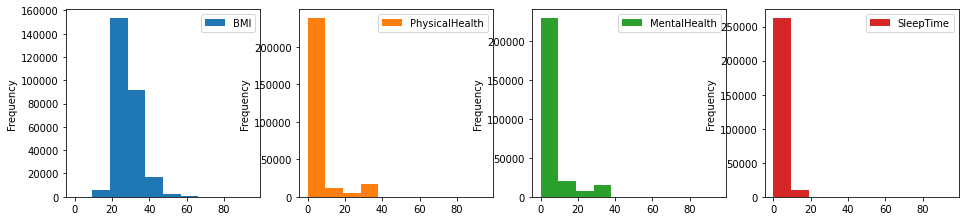

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

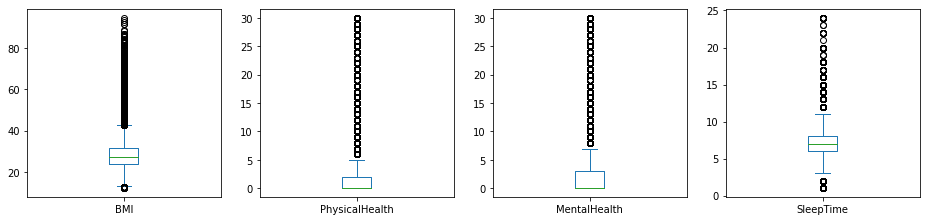

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

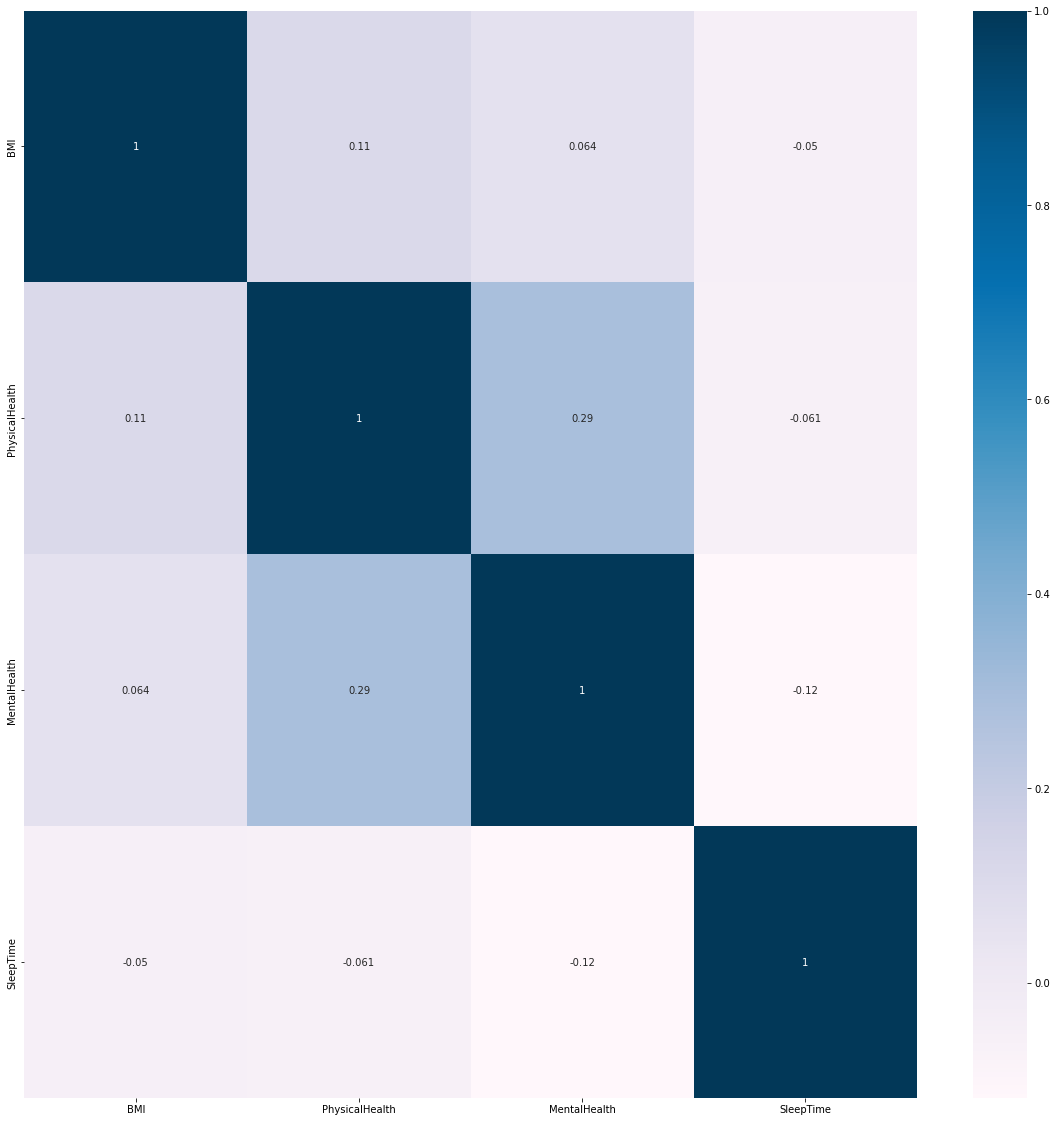

In [26]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [29]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [30]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpisfls9fk as temporary training directory
Starting reading the dataset
266/272 [============================>.] - ETA: 0s
Dataset read in 0:00:05.697133
Training model
Model trained in 0:00:40.181962
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


272/272 [==============================] - 54s 187ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model training time: 0:00:56.129368 



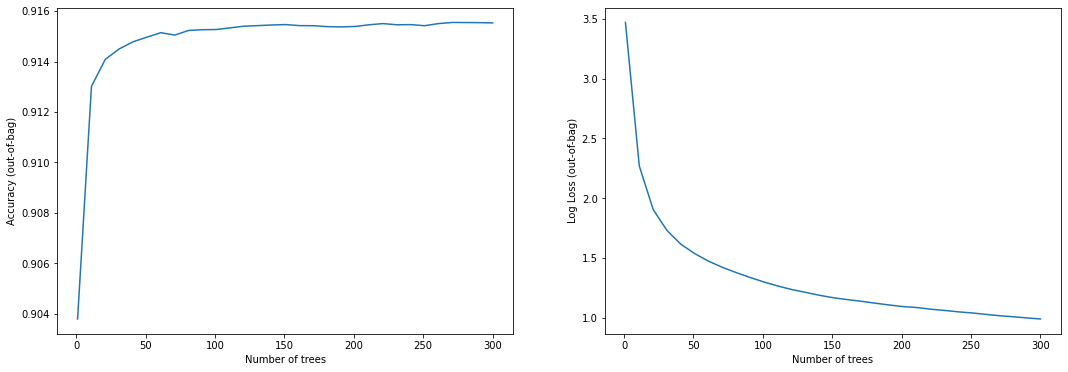

In [31]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [32]:
RF_eval = RF_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

272/272 [==============================] - 25s 88ms/step - loss: 0.0000e+00 - accuracy: 0.9268 - auc: 0.8847

loss: 0.0000
accuracy: 0.9268
auc: 0.8847


### 3.c) Train and Evaluate the Decision Trees Model

In [33]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpi53bncgl as temporary training directory
Starting reading the dataset
265/272 [============================>.] - ETA: 0s
Dataset read in 0:00:02.523616
Training model
Model trained in 0:00:01.018436
Compiling model
272/272 [==============================] - 4s 12ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


Model training time: 0:00:03.886015 



In [34]:
CART_eval = CART_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

272/272 [==============================] - 3s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9192 - auc: 0.8409

loss: 0.0000
accuracy: 0.9192
auc: 0.8409


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [35]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp5l85vmqi as temporary training directory
Starting reading the dataset
267/272 [============================>.] - ETA: 0s
Dataset read in 0:00:02.498580
Training model
Model trained in 0:00:20.183804
Compiling model
272/272 [==============================] - 23s 83ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1001] Use fast generic engine


Model training time: 0:00:23.057642 



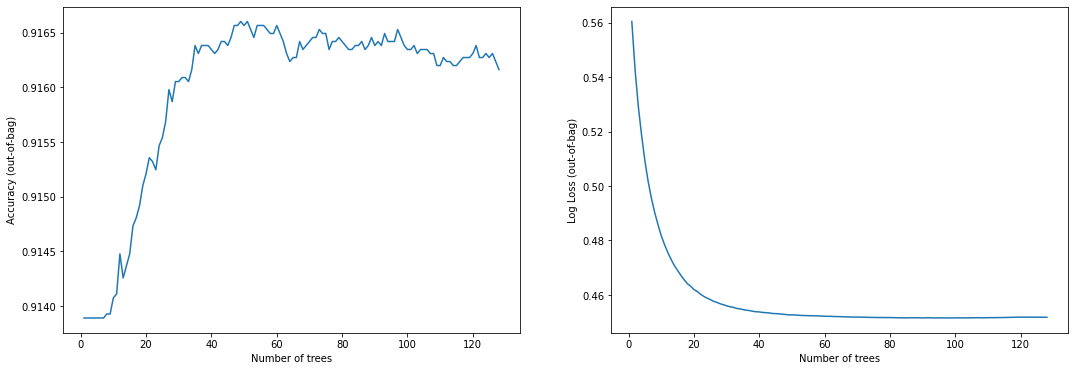

In [36]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [37]:
GBT_eval = GBT_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

272/272 [==============================] - 3s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9180 - auc: 0.8393

loss: 0.0000
accuracy: 0.9180
auc: 0.8393


In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Not applicable for this iteration of modeling

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [42]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [43]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp2qmm_h22 as temporary training directory
Starting reading the dataset
272/272 [==============================] - ETA: 0s
Dataset read in 0:00:02.548540
Training model
Model trained in 0:00:42.090583
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


272/272 [==============================] - 52s 193ms/step
Model training time: 0:00:53.568815 



In [44]:
Final_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (17):
	AgeCategory
	AlcoholDrinking
	Asthma
	BMI
	Diabetic
	DiffWalking
	GenHealth
	KidneyDisease
	MentalHealth
	PhysicalActivity
	PhysicalHealth
	Race
	Sex
	SkinCancer
	SleepTime
	Smoking
	Stroke

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.          "__LABEL" 13.567508 ################
    2.  "AlcoholDrinking" 13.171601 ###############
    3. "PhysicalActivity" 12.714997 ##############
    4.           "Asthma" 12.690665 ##############
    5.       "SkinCancer" 12.322767 ##############
    6.     "MentalHealth" 11.673380 #############
    7.        "SleepTime" 11.039937 ############
    8.             "Race" 10.19

### 5.b) Load Test Dataset and Make Predictions

In [45]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_test, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


In [46]:
Final_eval = Final_model.evaluate(tfds_test, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

48/48 [==============================] - 5s 92ms/step - loss: 0.0000e+00 - accuracy: 0.9159 - auc: 0.8317

loss: 0.0000
accuracy: 0.9159
auc: 0.8317


In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:03:00.261052
